## Regression Modeling of Coffee Bean Trading Volume with Market Price Indicators

With the recent wholesale price of coffee beans reaching a record high in December 2024, consumers are uneasy that the price of a coffee will skyrocket to $10-12 a cup. The increasing cost of this commodity is associated with recent unfavourable growing conditions as well as additional geopolitical factors impacting supply chains. In Australia, where locally grown coffee beans account for less than 1% of the market, the vast majority of coffee is imported, making the domestic market particularly sensitive to these price fluctuations.

To explore the dynamics of coffee bean trading, I wanted to investigate whether trading volume could be accurately predicted using market price indicators through regression modeling. Accurate predictions of trading volume could provide valuable insights for importers, distributors, and traders, enabling more effective inventory management and optimised trading strategies. Moreover, these improvements could have positive downstream effects on consumers by helping to mitigate unprecedented price inflations for their daily cups of coffee, an essential mental boost for many.

#### Methodology

For this project, I utilise a dataset compiled by Tesyon Hwase from the Department of Software Engineering at Nankai University, Ethiopia. The data, sourced from the Ethiopian Commodity Market, covers the period between 2012 and 2018 and includes 1,540 instances with 7 attributes. The attributes are date, open, high, low, adjusted close and volume (no information on the units).

This project adopts a supervised learning approach which begins with exploratory data analysis to uncover patterns and trends within the dataset. This includes identifying correlations between trading volume and market prices, visualizing relationships through scatterplots and heatmaps, and addressing any missing or inconsistent data. Feature engineering will play a critical role in assessing the importance of the existing attributes and, where appropriate, creating new features such as moving averages or volatility metrics to capture hidden patterns. 

Various regression models will be tested, including Linear Regression, Decision Tree, Random Forest, Gradient Boosting Machine, and Support Vector Regression. Model performance will be evaluated using metrics including Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), R² and bias scores. Hyperparameter tuning will be conducted using grid search or randomised search to optimize model accuracy and generalization.

The technical implementation will rely on Python as the primary programming language, utilising libraries including Pandas and NumPy for data preprocessing, Scikit-learn for machine learning, and Matplotlib and Seaborn for data visualization. Advanced models like XGBoost and LightGBM will be employed for complex patterns. The project will be developed using Jupyter Notebook for interactive analysis, with version control managed via GitHub.

Data source: https://data.mendeley.com/datasets/c55sbp7dgv/1

In [546]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# preprocessing
from sklearn.preprocessing import StandardScaler
# metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# regression models
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# model selection 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [547]:
# load the dataset
df = pd.read_excel('Coffee.xlsx')

### Data Exploration

In [548]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-05-31,970,1000,950,973,973,15.30
1,2011-06-01,955,970,955,955,955,112.20
2,2011-06-02,940,940,930,942,942,28.05
3,2011-06-03,950,950,940,950,950,53.55
4,2011-06-06,960,962,960,960,960,33.15


In [549]:
# convert date column to Pd.timestamp
df['Date'] = pd.to_datetime(df['Date'], yearfirst=True)

In [550]:
# set the index as the datetime column
df.set_index("Date", inplace=True)

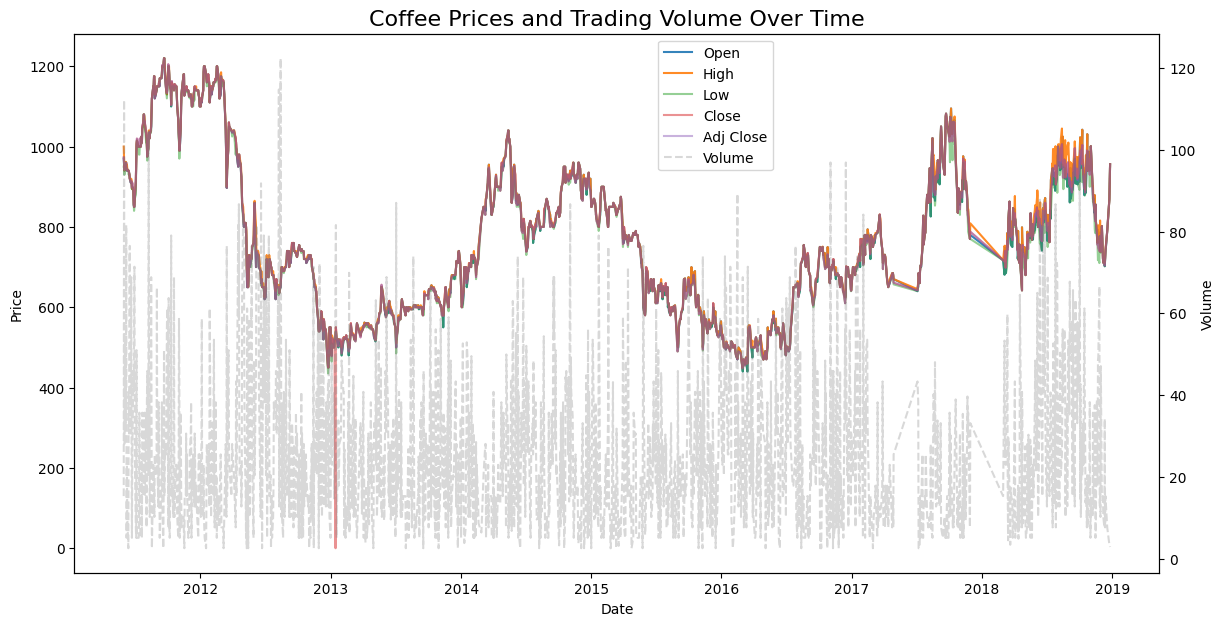

In [551]:
# visualise all price-related columns
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(df.index, df['Open'], label='Open', alpha=0.9)
ax1.plot(df.index, df['High'], label='High', alpha=0.9)
ax1.plot(df.index, df['Low'], label='Low', alpha=0.5)
ax1.plot(df.index, df['Close'], label='Close', alpha=0.5)
ax1.plot(df.index, df['Adj Close'], label='Adj Close', alpha=0.5)
ax1.set_xlabel("Date")
ax1.set_ylabel("Price")
ax1.set_title("Coffee Prices and Trading Volume Over Time", fontsize=16)
# add volume on a second y-axis
ax2 = ax1.twinx()
ax2.plot(df.index, df['Volume'], label='Volume', color='gray', alpha=0.3, linestyle='--')
ax2.set_ylabel("Volume")
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, bbox_to_anchor=(0.65, 1))
plt.show()

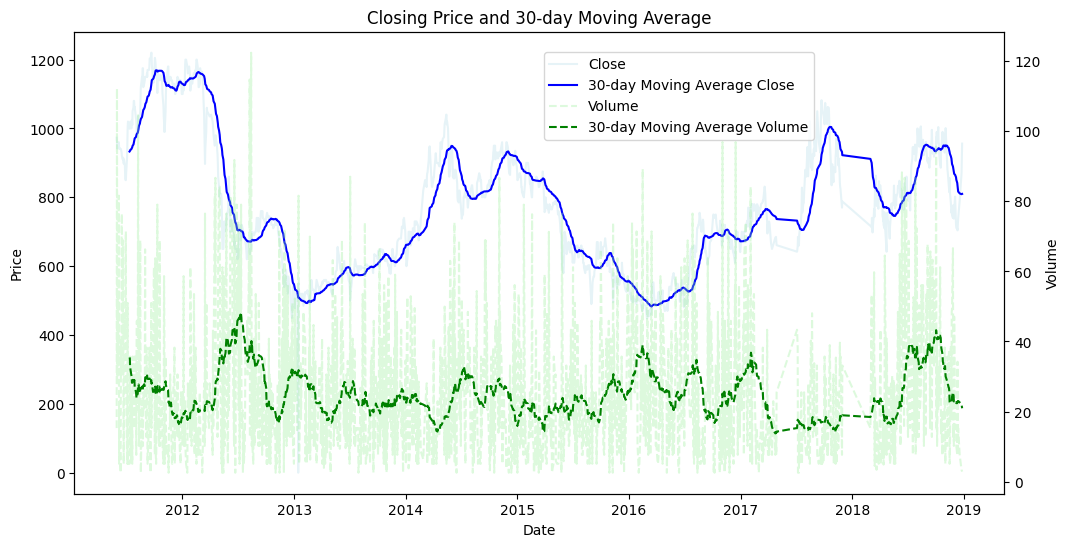

In [552]:
# calculate 30-day moving average of closing price and volume
df[['Close_30_MA', 'Volume_30_MA']] = df[['Close','Volume']].rolling(window=30).mean()
# visualise closing prices and 30-day moving average together
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df.index, df['Close'], label='Close', color ='lightblue', alpha=0.3)
ax1.plot(df.index,df['Close_30_MA'], label='30-day Moving Average Close', color='blue')
ax1.set_title('Closing Price and 30-day Moving Average')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax2=ax1.twinx()
ax2.plot(df.index, df['Volume'], label='Volume', color='lightgreen', alpha=0.3, linestyle='--')
ax2.plot(df.index, df['Volume_30_MA'], label='30-day Moving Average Volume', color='green', alpha=1, linestyle='--')
ax2.set_ylabel("Volume")
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, bbox_to_anchor=(0.65, 0.75))
plt.show()

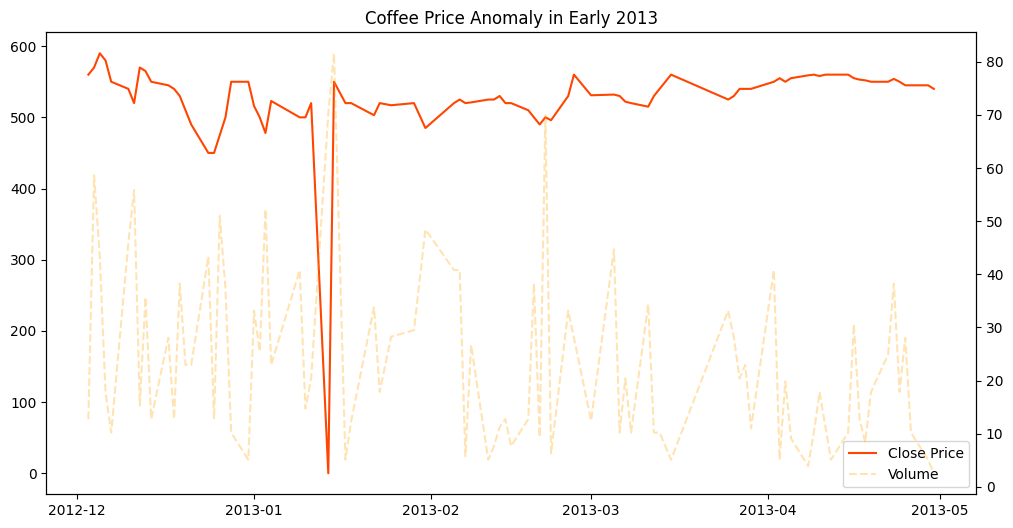

In [553]:
# visualise the dip in 2013
df_2013 = df["2012-12-1":"2013-5-1"]
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_2013.index, df_2013['Close'], label='Close Price', color ='orangered')
ax1.set_title('Coffee Price Anomaly in Early 2013')
ax2=ax1.twinx()
ax2.plot(df_2013.index, df_2013['Volume'], label='Volume', color='orange', alpha=0.3, linestyle='--')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="lower right")
plt.show()

In [554]:
# display the data to inspect the dip
print(df_2013[df_2013['Close'] == df_2013['Close'].min()])  # Highlight the lowest point
print(df_2013.head(10))  # View the first few rows in this range

            Open  High  Low  Close  Adj Close  Volume  Close_30_MA  \
Date                                                                 
2013-01-14   530   540  530      0        535    70.3   508.733333   

            Volume_30_MA  
Date                      
2013-01-14        31.506  
            Open  High  Low  Close  Adj Close  Volume  Close_30_MA  \
Date                                                                 
2012-12-03   560   560  560    560        560   12.75   663.166667   
2012-12-04   570   575  570    570        570   58.65   658.166667   
2012-12-05   590   590  585    590        590   43.35   653.833333   
2012-12-06   580   580  580    580        580   17.85   649.166667   
2012-12-07   550   580  550    550        550   10.20   643.833333   
2012-12-10   540   540  540    540        540   45.90   637.833333   
2012-12-11   520   565  520    520        520   55.86   630.833333   
2012-12-12   570   570  565    570        570   15.30   625.500000   
2012-12-

An outlier is observed on 2013-01-14, where the closing price is recorded as zero. This value is inconsistent with other price-related variables, particularly the adjusted closing price. I plan to impute this missing value using the adjusted closing price for that day.

In [555]:
# drop added columns 
df.drop(columns=['Close_30_MA'], inplace=True)
df.drop(columns=['Volume_30_MA'], inplace=True)

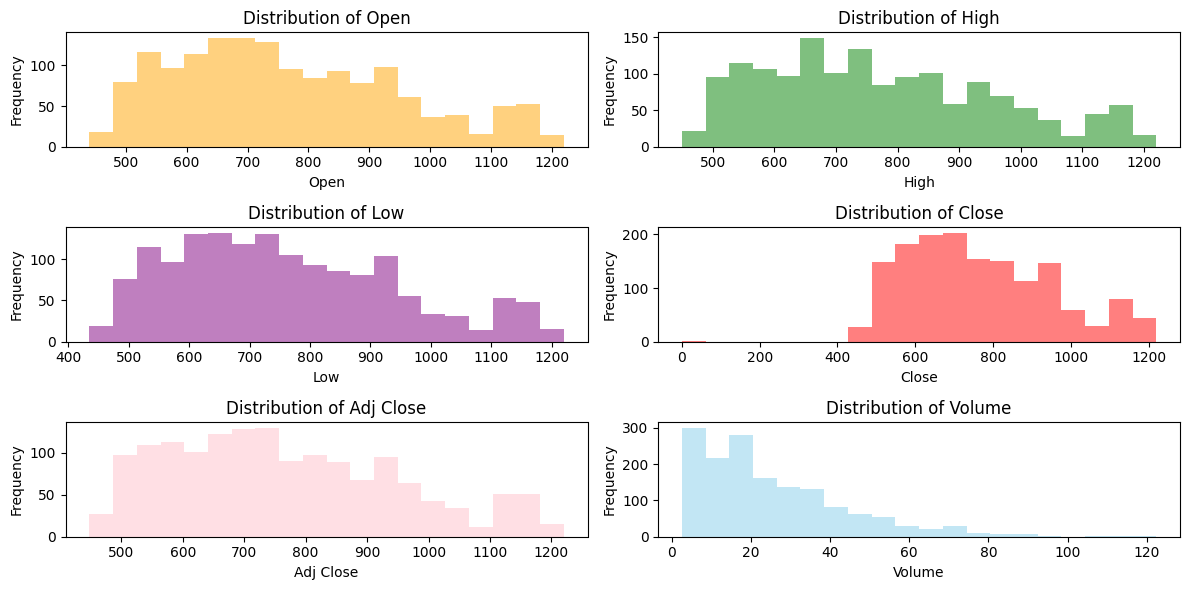

In [556]:
# show distribution of each of the columns
columns = df.columns
colors = ['skyblue', 'orange', 'green', 'purple', 'red', 'pink']
plt.figure(figsize=(12,6))
for i, column in enumerate(columns,1):
    plt.subplot(3,2,i)
    plt.hist(df[column], bins=20, color=colors[i % len(colors)], alpha=0.5)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

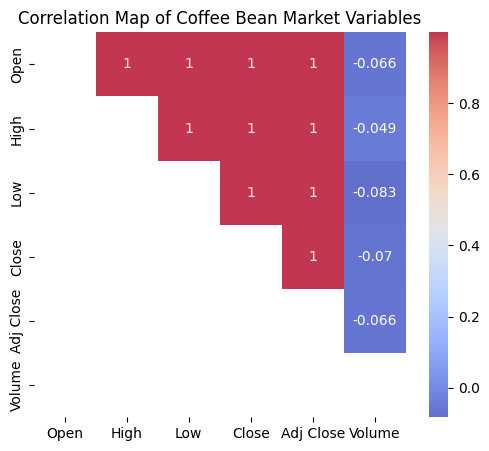

In [557]:
# correlation heatmap
corr=df.corr()
mask = np.tril(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(df.corr(), mask=mask, annot=True, cmap='coolwarm', alpha=0.8, ax=ax)
plt.title('Correlation Map of Coffee Bean Market Variables')
plt.show()

The Volume column exhibits a weak negative correlation with all the price-related variables (Open, High, Low, Close, and Adj Close). This indicates that trading volume is not strongly influenced by price values in this dataset. To improve the relationship between features and trading volume, I plan to explore feature engineering techniques, such as deriving volatility measures, rolling averages, or lagged variables, which may better capture patterns affecting trading volume.

### Data Preparation

#### Data Cleaning and Feature Engineering

In [558]:
# show any zero values in the data
rows_with_zeros = df[(df == 0).any(axis=1)]
print(rows_with_zeros)

            Open  High  Low  Close  Adj Close  Volume
Date                                                 
2013-01-14   530   540  530      0        535    70.3


In [559]:
# impute the zero value
df['Close'] = df.apply(lambda row: row['Adj Close'] if row['Close'] == 0 else row['Close'], axis=1)

In [560]:
# verify the change
print(df.loc['2013-01-14'])

Open         530.0
High         540.0
Low          530.0
Close        535.0
Adj Close    535.0
Volume        70.3
Name: 2013-01-14 00:00:00, dtype: float64


In [561]:
# show any zero values
rows_with_zeros = df[(df == 0).any(axis=1)]
print(rows_with_zeros)

Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []


In [562]:
## VOLATILITY
# volatility of daily price range
df['Price_Range'] = df['High'] - df['Low']
# relative volatility by normalising with closing price
df['Relative_Vol'] = (df['High'] - df['Low']) / df['Close']
# rolling volatility by finding the std of closing price
df['Rolling_Vol'] = df['Close'].rolling(window=20).std()

## PRICE MOMENTUM
# daily percentage change in closing price
df['Daily_Price_Change'] = df['Close'].pct_change() * 100
# cumulative sum of daily price changes
df['Cumulative_Price_Change'] = df['Daily_Price_Change'].cumsum()

## MOVING AVERAGES
# 5-day moving average (weekly)
df['MA_week'] = df['Close'].rolling(window=5).mean()
# 20-day moving average (monthly)
df['MA_month'] = df['Close'].rolling(window=20).mean()
# difference between short term and long term moving averages (Moving Average Convergence Divergence)
df['MACD'] = df['MA_week'] - df['MA_month']

## LAGGED VARIABLES
# lagged Variables for Volume (3, 7, 14 days)
df['Volume_Lag3'] = df['Volume'].shift(3)
df['Volume_Lag7'] = df['Volume'].shift(7)
df['Volume_Lag14'] = df['Volume'].shift(14)

# lagged Variables for Close Price (3, 7, 14 days)
df['Close_Lag3'] = df['Close'].shift(3)
df['Close_Lag7'] = df['Close'].shift(7)
df['Close_Lag14'] = df['Close'].shift(14)

## CUMULATIVE VOLUME
# weekly cumulative volume (lagged to exclude current value)
df['Weekly_Cumulative_Volume'] = df['Volume'].rolling(window=5).sum().shift(1)
# monthly cumulative volume (lagged to exclude current value)
df['Monthly_Cumulative_Volume'] = df['Volume'].rolling(window=20).sum().shift(1)

# TIME FEATURES
# month of year
df['Month'] = df.index.month

In [563]:
# inspect the shape of the dataframe
print(df.shape)

(1539, 23)


In [564]:
# inspect first few rows
df.head()

,Open,High,Low,Close,Adj Close,Volume,Price_Range,Relative_Vol,Rolling_Vol,Daily_Price_Change,...,MACD,Volume_Lag3,Volume_Lag7,Volume_Lag14,Close_Lag3,Close_Lag7,Close_Lag14,Weekly_Cumulative_Volume,Monthly_Cumulative_Volume,Month
Date,,,,,,,,,,,,,,,,,,,,,
2011-05-31,970,1000,950,973.0,973,15.30,50,0.051387,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
2011-06-01,955,970,955,955.0,955,112.20,15,0.015707,NaN,-1.849949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
2011-06-02,940,940,930,942.0,942,28.05,10,0.010616,NaN,-1.361257,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
2011-06-03,950,950,940,950.0,950,53.55,10,0.010526,NaN,0.849257,...,NaN,15.3,NaN,NaN,973.0,NaN,NaN,NaN,NaN,6
2011-06-06,960,962,960,960.0,960,33.15,2,0.002083,NaN,1.052632,...,NaN,112.2,NaN,NaN,955.0,NaN,NaN,NaN,NaN,6


In [565]:
# remove rows with NA values (first 20 rows)
df_new = df.dropna()

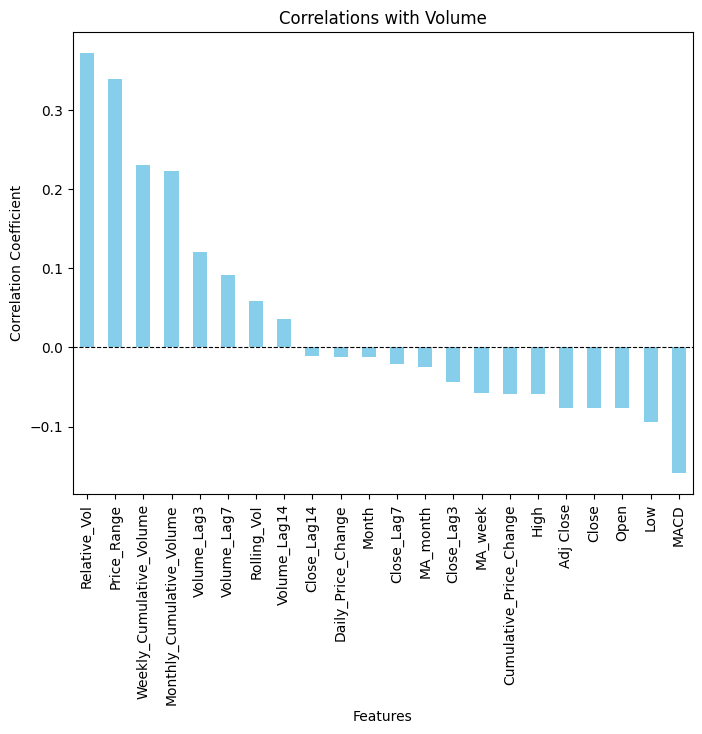

In [566]:
# show correlation of new variables with volume
corr=df_new.corr()
volume_corr = corr['Volume'].sort_values(ascending=False)

# plot the correlations with volume
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
volume_corr.drop('Volume').plot(kind='bar', color='skyblue')
plt.title("Correlations with Volume")
plt.xlabel("Features")
plt.ylabel("Correlation Coefficient")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()

In [567]:
# split into feature and target variables
X = df_new.drop(columns=['Volume'])
y = df_new['Volume']

In [568]:
# show a sample of the feature variables
X.head()

,Open,High,Low,Close,Adj Close,Price_Range,Relative_Vol,Rolling_Vol,Daily_Price_Change,Cumulative_Price_Change,...,MACD,Volume_Lag3,Volume_Lag7,Volume_Lag14,Close_Lag3,Close_Lag7,Close_Lag14,Weekly_Cumulative_Volume,Monthly_Cumulative_Volume,Month
Date,,,,,,,,,,,,,,,,,,,,,
2011-06-28,855,860,855,855.0,855,5,0.005848,26.484156,-3.932584,-12.738564,...,-34.80,5.10,76.50,5.10,898.0,920.0,945.0,170.85,787.95,6
2011-06-29,850,850,840,850.0,850,10,0.011765,30.783240,-0.584795,-13.323359,...,-41.55,25.50,30.60,22.95,910.0,910.0,940.0,142.80,813.45,6
2011-06-30,850,855,850,850.0,850,5,0.005882,34.330399,0.000000,-13.323359,...,-46.55,45.90,68.85,10.20,890.0,915.0,943.0,175.95,759.90,6
2011-07-01,870,870,870,870.0,870,0,0.000000,35.004473,2.352941,-10.970418,...,-50.55,40.80,25.50,2.55,855.0,910.0,940.0,242.25,803.25,7
2011-07-04,914,914,880,914.0,914,34,0.037199,33.259546,5.057471,-5.912947,...,-43.45,58.65,5.10,40.80,850.0,898.0,940.0,242.25,775.20,7


In [569]:
y.head()

Date
2011-06-28    40.80
2011-06-29    58.65
2011-06-30    71.40
2011-07-01    25.50
2011-07-04     7.65
Name: Volume, dtype: float64

#### Split into Training, Validation and Test Sets 

In [570]:
# split into training, validation and test sets
val_mask = (df_new.index.year == 2017)
test_mask = (df_new.index.year == 2018)

X_train = X[~(val_mask | test_mask)]  
y_train = y[~(val_mask | test_mask)] 

X_val = X_df[val_mask]               
y_val = y[val_mask]  

X_test = X[test_mask]  
y_test = y[test_mask] 

# Print information about the splits
print(f"# of Training samples: {len(X_train)}")
print(f"# of Validation samples: {len(X_val)}")
print(f"# of Test samples: {len(X_test)}")

print(f"Min Date in Train: {X_train.index.min()} | Max Date in Train: {X_train.index.max()}")
print(f"Min Date in Validation: {X_val.index.min()} | Max Date in Validation: {X_val.index.max()}")
print(f"Min Date in Test: {X_test.index.min()} | Max Date in Test: {X_test.index.max()}")

# of Training samples: 1190
# of Validation samples: 135
# of Test samples: 194
Min Date in Train: 2011-06-28 00:00:00 | Max Date in Train: 2016-12-30 00:00:00
Min Date in Validation: 2017-01-04 00:00:00 | Max Date in Validation: 2017-11-29 00:00:00
Min Date in Test: 2018-03-01 00:00:00 | Max Date in Test: 2018-12-26 00:00:00


#### Transformation Pipelines

In [571]:
# function to train and evaluate the models
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_metrics, scale_features=True):

    # for scaling the features
    if scale_features:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

    # training the model
    model.fit(X_train, y_train)

    # predict on validation and test sets
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # compute metrics for validation and test set
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(y_val, y_val_pred)
    
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_test_pred)

    # compute bias
    val_bias = np.mean(y_val_pred - y_val)
    test_bias = np.mean(y_test_pred - y_test)

    # print results
    print(f"Model: {model.__class__.__name__}")
    print(f"Validation MAE: {val_mae}, RMSE: {val_rmse}, MSE: {val_mse}, R²: {val_r2}, Bias: {val_bias}")
    print(f"Test MAE: {test_mae}, RMSE: {test_rmse}, MSE: {test_mse}, R²: {test_r2}, Bias: {test_bias}")

    # return metrics and model name as a dictionary
    model_metrics[model.__class__.__name__] = {
        "validation": {"MAE": val_mae, "RMSE": val_rmse, "MSE": val_mse, "R²": val_r2, "Bias": val_bias},
        "test": {"MAE": test_mae, "RMSE": test_rmse, "MSE": test_mse, "R²": test_r2,  "Bias": test_bias},
    }

    return y_val_pred, y_test_pred, model_metrics

model_metrics = {}

In [572]:
def plot_actual_vs_predicted(model, model_name, y_test, y_test_pred, xlabel="Date", ylabel="Volume"):
    plt.figure(figsize=(12,6))
    plt.plot(y_test.index, y_test.values, label="Actual", color="blue")
    plt.plot(y_test.index, y_test_pred, label="Predicted", color="red", linestyle="--")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"Actual vs Predicted Volume for {model_name}")
    plt.legend()
    plt.show()

### Training Models

#### Linear Regression

In [573]:
linear_model = LinearRegression()

# train and evaluate
y_val_pred_lr, y_test_pred_lr, model_metrics = train_and_evaluate_model(
    model=linear_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    model_metrics=model_metrics
)

Model: LinearRegression
Validation MAE: 12.985011747492758, RMSE: 17.23409406951536, MSE: 297.0139983969045, R²: -0.3029947772120123, Bias: 5.398709092005057
Test MAE: 19.4543843566058, RMSE: 24.68655163755777, MSE: 609.4258317538062, R²: -0.5521605817984472, Bias: 16.03036584210962


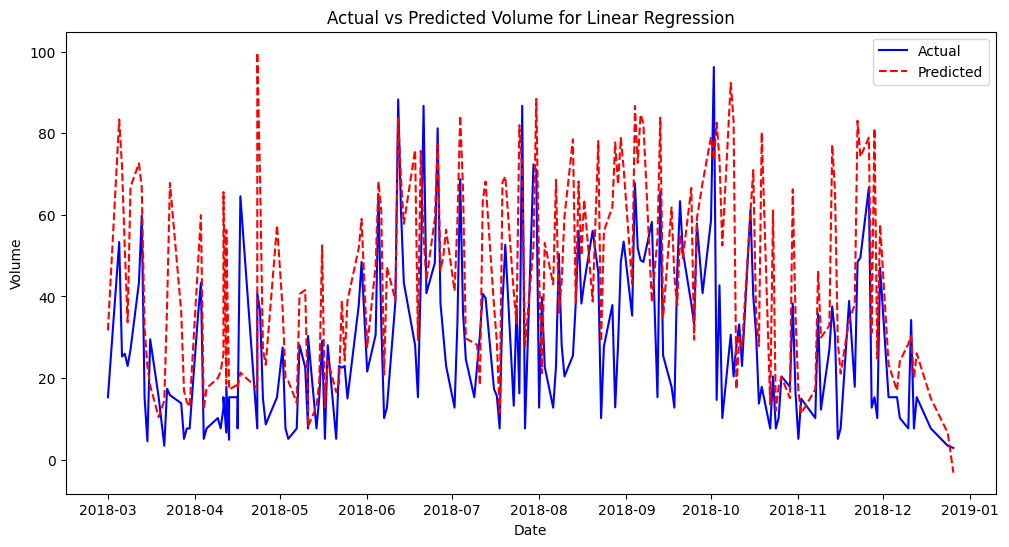

In [574]:
# visualise actual vs predicted prices
plot_actual_vs_predicted(
    model=linear_model,
    model_name = "Linear Regression",
    y_test=y_test,
    y_test_pred=y_test_pred_lr
)

#### Ridge Regression

In [575]:
ridge_model = RidgeCV()

# train and evaluate
y_val_pred_ridge, y_test_pred_ridge, model_metrics = train_and_evaluate_model(
    model=ridge_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    model_metrics=model_metrics
)

Model: RidgeCV
Validation MAE: 12.732302334802503, RMSE: 16.93120330068881, MSE: 286.6656452092557, R²: -0.25759674806513977, Bias: 5.272022949483121
Test MAE: 18.8568151913255, RMSE: 23.92387439117485, MSE: 572.3517658847117, R²: -0.4577357959579702, Bias: 15.257764609489636


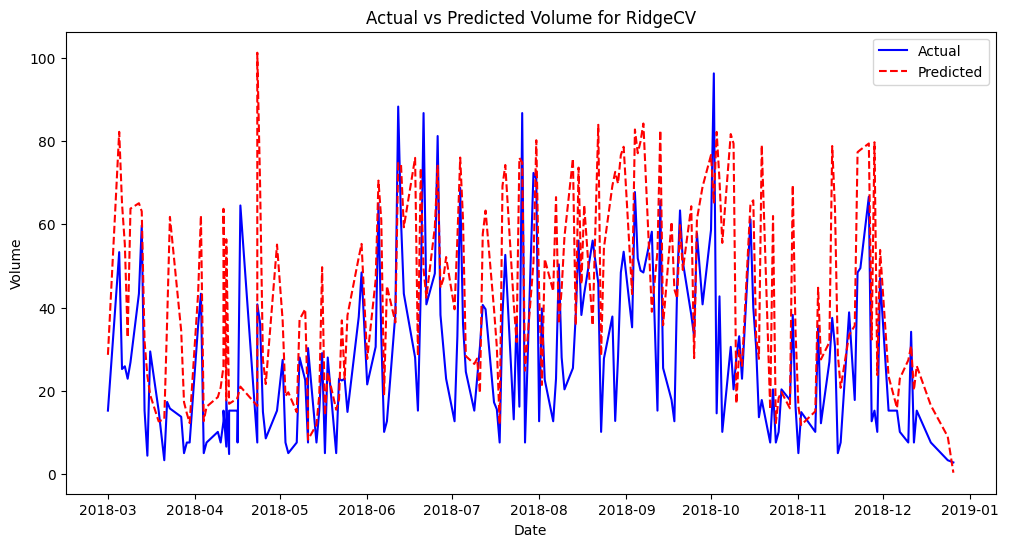

In [576]:
# visualise actual vs predicted prices
plot_actual_vs_predicted(
    model=ridge_model,
    model_name = "RidgeCV",
    y_test=y_test,
    y_test_pred=y_test_pred_ridge
)

#### Decision Tree

In [577]:
tree_model = DecisionTreeRegressor(max_depth=50, random_state=42)

# train and evaluate
y_val_pred_tree, y_test_pred_tree, model_metrics = train_and_evaluate_model(
    model=tree_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    model_metrics=model_metrics
)

Model: DecisionTreeRegressor
Validation MAE: 15.892740740740743, RMSE: 21.898406402360948, MSE: 479.54020296296295, R²: -1.1037337744901423, Bias: 5.655703703703704
Test MAE: 22.15278350515464, RMSE: 29.994737167242505, MSE: 899.684257731959, R²: -1.2914264019584203, Bias: 9.854845360824743


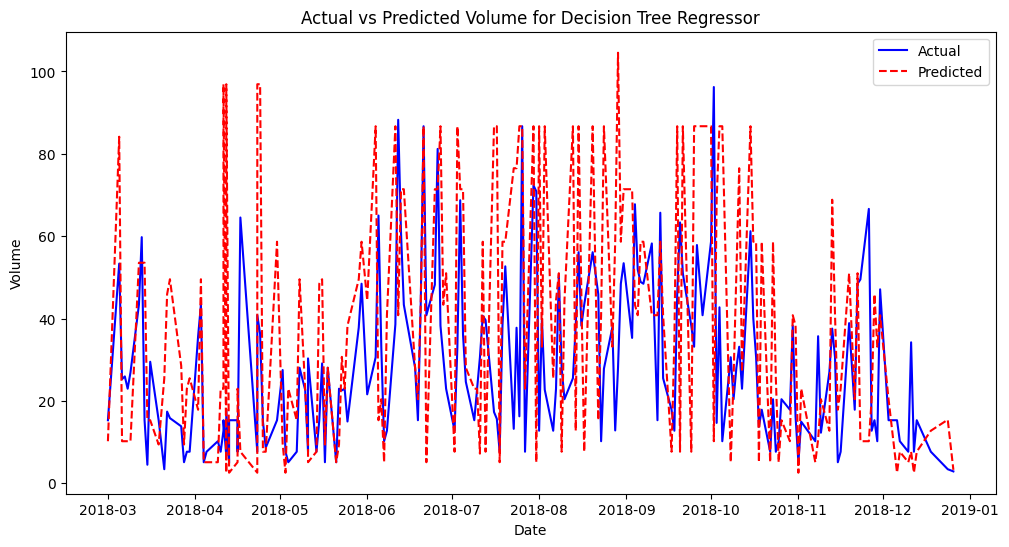

In [578]:
# visualise actual vs predicted prices
plot_actual_vs_predicted(
    model=tree_model,
    model_name = "Decision Tree Regressor",
    y_test=y_test,
    y_test_pred=y_test_pred_tree
)

#### Random Forest

In [579]:
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# train and evaluate
y_val_pred_forest, y_test_pred_forest, model_metrics = train_and_evaluate_model(
    model=forest_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    model_metrics=model_metrics
)

Model: RandomForestRegressor
Validation MAE: 11.614221481481483, RMSE: 14.748630227895239, MSE: 217.52209359918518, R²: 0.04573470133482216, Bias: 5.349095555555556
Test MAE: 13.663843814432992, RMSE: 17.039443386822587, MSE: 290.34263093273194, R²: 0.26051971631636295, Bias: 5.743724226804122


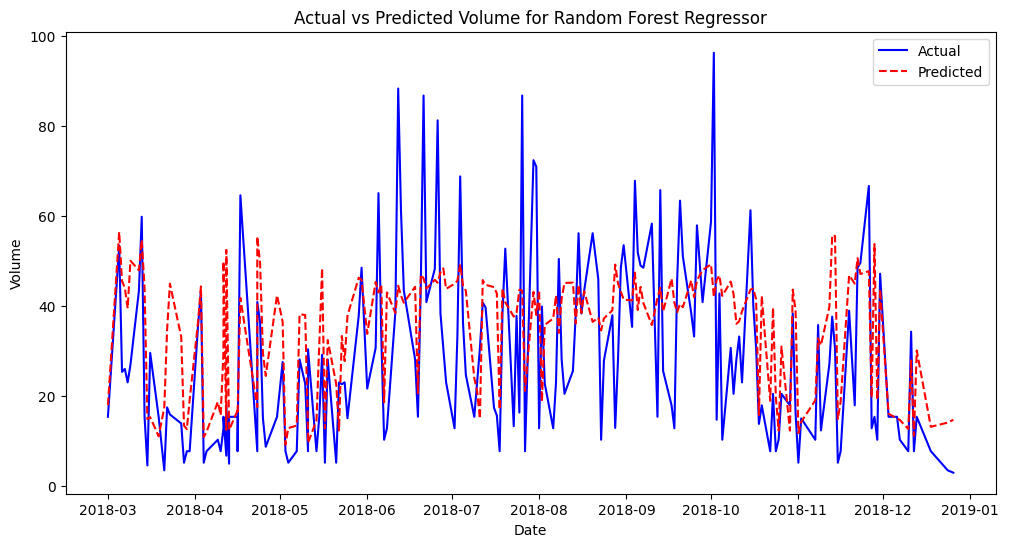

In [580]:
# visualise actual vs predicted prices
plot_actual_vs_predicted(
    model=forest_model,
    model_name = "Random Forest Regressor",
    y_test=y_test,
    y_test_pred=y_test_pred_forest
)

#### Support Vector Regressor

In [581]:
svr_model = SVR(kernel='rbf')

# train and evaluate
y_val_pred_svr, y_test_pred_svr, model_metrics = train_and_evaluate_model(
    model=svr_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    model_metrics=model_metrics
)

Model: SVR
Validation MAE: 9.94984707920068, RMSE: 13.768520111250679, MSE: 189.5721460539144, R²: 0.1683505910619142, Bias: -0.6264077524314416
Test MAE: 14.18750818226133, RMSE: 19.624978165999956, MSE: 385.13976801597494, R²: 0.019078720905136404, Bias: -7.012082479439769


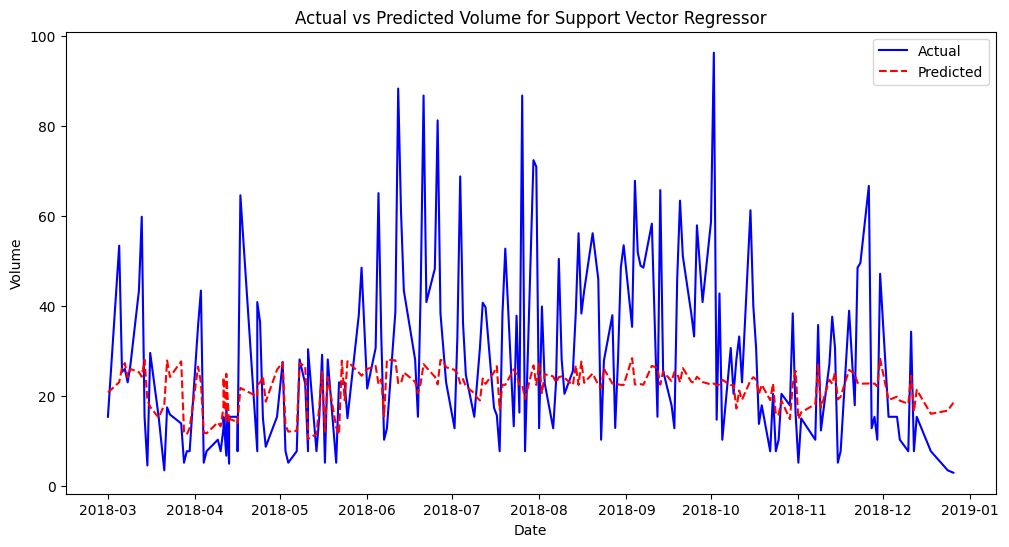

In [582]:
# visualise actual vs predicted prices
plot_actual_vs_predicted(
    model=svr_model,
    model_name = "Support Vector Regressor",
    y_test=y_test,
    y_test_pred=y_test_pred_svr
)

#### Gradient Boosting Regressor

In [583]:
gbm_model = GradientBoostingRegressor(random_state=42)

# train and evaluate
y_val_pred_gbm, y_test_pred_gbm, model_metrics = train_and_evaluate_model(
    model=gbm_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    model_metrics=model_metrics
)

Model: GradientBoostingRegressor
Validation MAE: 10.374288629998581, RMSE: 13.986538037980168, MSE: 195.62324628786612, R²: 0.14180452911270858, Bias: 2.9271362409165413
Test MAE: 13.116706631294683, RMSE: 17.06011897910723, MSE: 291.0476595812947, R²: 0.2587240627350428, Bias: 6.463141516022812


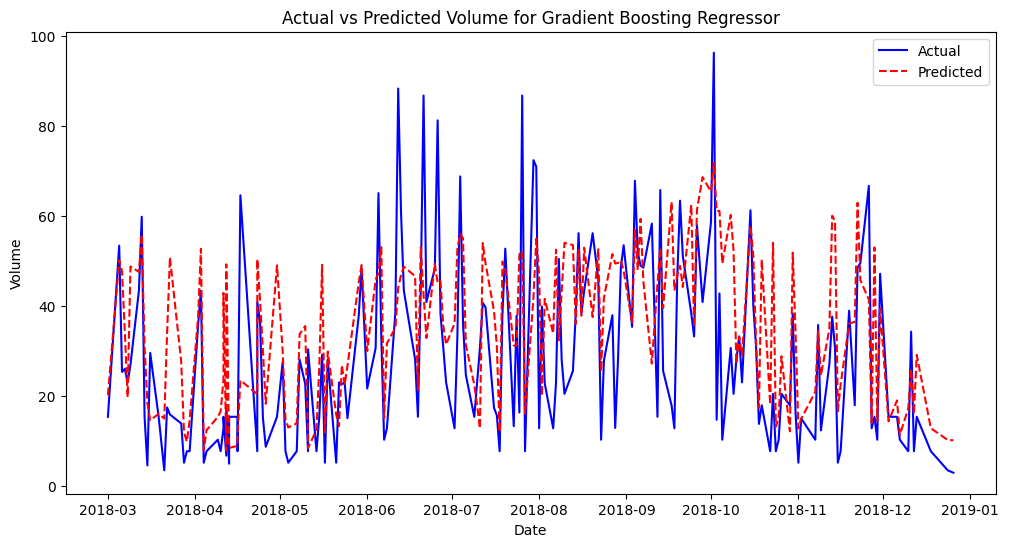

In [584]:
# visualise actual vs predicted prices
plot_actual_vs_predicted(
    model=gbm_model,
    model_name = "Gradient Boosting Regressor",
    y_test=y_test,
    y_test_pred=y_test_pred_gbm
)

#### XGBRegressor

In [585]:
xgb_model = XGBRegressor(random_state=42)

# train and evaluate
y_val_pred_xgb, y_test_pred_xgb, model_metrics = train_and_evaluate_model(
    model=xgb_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    model_metrics=model_metrics,
    scale_features=False 
)

Model: XGBRegressor
Validation MAE: 11.595653611077203, RMSE: 15.192541903639382, MSE: 230.81332949383855, R²: -0.012573698427142288, Bias: 2.419702671757451
Test MAE: 14.997579288187714, RMSE: 19.025430616341172, MSE: 361.967010137212, R²: 0.07809794765413547, Bias: 0.15782616340007988


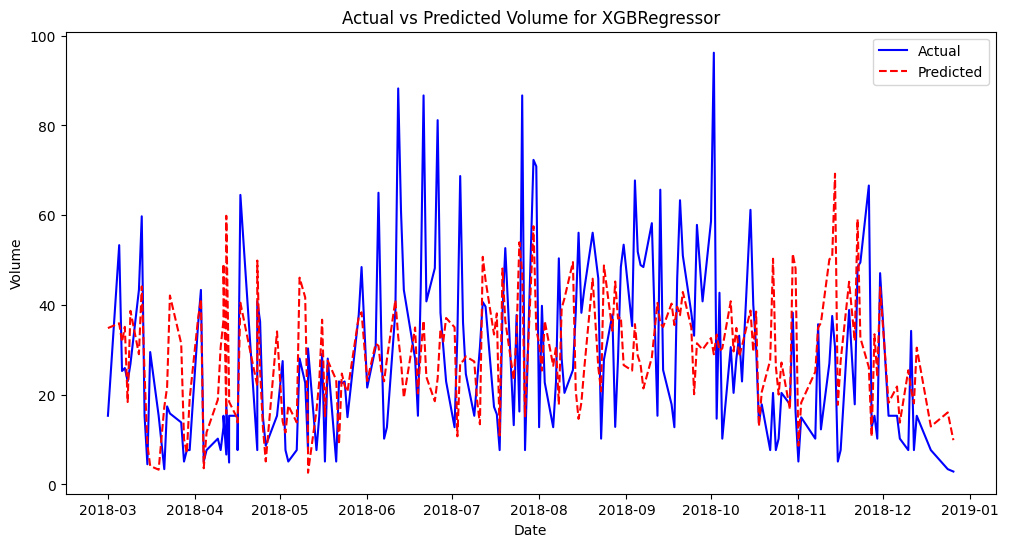

In [586]:
# visualise actual vs predicted prices
plot_actual_vs_predicted(
    model=xgb_model,
    model_name = "XGBRegressor",
    y_test=y_test,
    y_test_pred=y_test_pred_xgb
)

#### LGBMRegressor

In [587]:
lgbm_model = LGBMRegressor(random_state=42, force_col_wise=True)

# train and evaluate
y_val_pred_lgbm, y_test_pred_lgbm, model_metrics = train_and_evaluate_model(
    model=lgbm_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    model_metrics=model_metrics
)

[LightGBM] [Info] Total Bins 3624
[LightGBM] [Info] Number of data points in the train set: 1190, number of used features: 22
[LightGBM] [Info] Start training from score 25.204361
Model: LGBMRegressor
Validation MAE: 10.520029055068319, RMSE: 13.933327401751825, MSE: 194.13761248440824, R²: 0.14832197642900802, Bias: 2.246014401333314
Test MAE: 12.592090565663062, RMSE: 16.65592492088764, MSE: 277.41983497024586, R²: 0.2934330807562511, Bias: 2.789842274036551


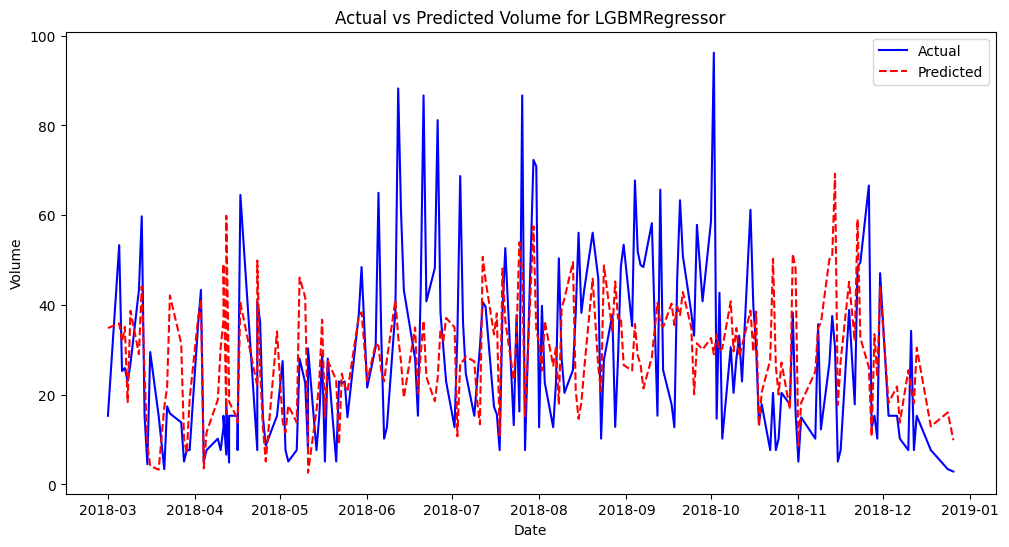

In [591]:
# visualise actual vs predicted prices
plot_actual_vs_predicted(
    model=lgbm_model,
    model_name = "LGBMRegressor",
    y_test=y_test,
    y_test_pred=y_test_pred_xgb
)

In [588]:
# convert dictionary to DataFrame
formatted_table = []

for model, metrics in model_metrics.items():
    formatted_table.append({
        "Algorithm": model,
        "MAE": metrics["test"]["MAE"],
        "RMSE": metrics["test"]["RMSE"],
        "Bias": metrics["test"]["Bias"],
        "R²": metrics["test"]["R²"]
    })

# create a DataFrame
df_metrics_table = pd.DataFrame(formatted_table)

In [589]:
print(df_metrics_table)

                   Algorithm        MAE       RMSE       Bias        R²
0           LinearRegression  19.454384  24.686552  16.030366 -0.552161
1                    RidgeCV  18.856815  23.923874  15.257765 -0.457736
2      DecisionTreeRegressor  22.152784  29.994737   9.854845 -1.291426
3      RandomForestRegressor  13.663844  17.039443   5.743724  0.260520
4                        SVR  14.187508  19.624978  -7.012082  0.019079
5  GradientBoostingRegressor  13.116707  17.060119   6.463142  0.258724
6               XGBRegressor  14.997579  19.025431   0.157826  0.078098
7              LGBMRegressor  12.592091  16.655925   2.789842  0.293433


Overall, tree-based models, including RandomForestRegressor, GradientBoostingRegressor, and LGBMRegressor, outperformed both linear models and support vector regression. Among these, LGBMRegressor demonstrated the best performance, achieving the lowest RMSE (16.66) and MAE (12.59) and the highest R² (0.29), indicating that it explains the most variance.

Linear Regression and RidgeCV performed poorly, likely due to the non-linear nature of the data. Similarly, DecisionTreeRegressor underperformed, likely as a result of overfitting, as suggested by its very low bias.

Due to the time-series nature of the data, I was unable to conduct hyperparameter tuning for the tree-based models, which could potentially have further improved their performance.